In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import hashlib
import matplotlib
matplotlib.rc('font', size=15)

# Hexagon grid conversions

Define a tessellating hexagonal grid as a set of hexagons $\mathcal{H}$ which covers the cartesian plane $\mathbb{R}^2$. Each hexagon $h_{i,j} \in \mathcal{H}$ has an integer _address_ $\{i, j\} \in \mathbb{Z}^2$. The hexagons do not overlap so the intersection of any two distinct $h$ is empty, and the cartesian space is covered such that any coordinate $\{x, y\} \in \mathbb{R}^2$ belongs to some $h_{i,j}$.

We can therefore define the grid with a function $f : \mathbb{R}^2 \rightarrow \mathbb{Z}^2$ that maps coordinates in cartesian space to the corresponding hexagon address. This function is useful for example in the context of a computer interaction where a user selects a pixel location on a rendering of the hexagonal grid, and we which to find the corresponding grid address.

Without loss of generality, assume that the hex grid is "flat topped" as defined in [1], and the hexagonal grid addresses are "Axial Coordinates" as defined in [1].

[1]: <https://www.redblobgames.com/grids/hexagons/>

## Hexagon geometry

We need to determine the shape of each hexagon. Clearly the tessellation will be straightforward so long as each hexagon on the grid is identical - but they do not need to be regular, as any simple scaling of the coordinates could easily be inverted to get regular hexagons if that was so desired. A regular hexagon with side 1 has a height of $\sqrt{3}$ so it is in fact more convenient to choose a non-regular geometry.

Define the hexagon shape so that the distances between hexagons are small whole numbers: a small section of the tessellation is shown below - the vertical space between adjacent hexagons in the same "column" (labelled $h$) is 2, and the vertical space relative to the hexagon in the next column is 1. The horizontal space ($w$) is 1.

In [3]:
import numpy as np

def hex_points():
    return np.array([
        [1.25, 1.],
        [0.75, 2.],
        [0.25, 2.],
        [-0.25, 1.],
        [0.25, 0.],
        [0.75, 0.],
        [1.25, 1]
    ])

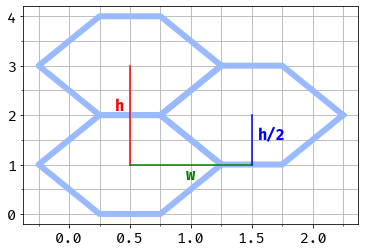

In [4]:
points = hex_points()
hex_color='#99baff'
plt.plot(*points.transpose(), lw=6, color=hex_color)
plt.plot(*(points + [1, 1]).transpose(), lw=6, color=hex_color)
plt.plot(*(points + [0, 2]).transpose(), lw=6, color=hex_color)
plt.grid(which='both')
ax = plt.gca()
ax.set_xticks(np.arange(-0.25, 2.26, 0.25), minor=True)
ax.set_yticks(np.arange(-0, 4.1, 0.5), minor=True)
plt.plot([0.5, 0.5], [1, 3], color='red')
plt.annotate('h', [0.5, 2.5], [0.45, 2.1], horizontalalignment='right', color='red', weight='bold')

plt.plot([0.5, 1.5], [1, 1], color='green')
plt.annotate('w', [0.7, 0.7], [1, 0.7], horizontalalignment='center', color='green', weight='bold')

plt.plot([1.5, 1.5], [1, 2], color='blue')
plt.annotate(r'h/2', [1.5, 1.5], [1.55,1.5], horizontalalignment='left', color='blue', weight='bold')

None

## Colouring the hexagons

As noted at the start, each hexagon has an address $\{i, j\}$. In order to better understand our representations of the grid, we will pick a pseudo-random colour for each hexagon using its address and the SHA-256 hash function.


In [5]:
import hashlib

def color_for_hex(i, j):
    """Calculates a size 3 array of floats that can be used as a color
    
    The input values are put into a byte string and passed to the sha256
    hash function. 
    """
    buffer = np.array([i, j], dtype=np.int32).tobytes()
    hash_data = hashlib.sha256(buffer).digest()
    return np.frombuffer(hash_data, dtype=np.uint8)[:3].astype(float)/255

print(color_for_hex(1, 1))
# The function is deterministic, and only considers integer values, so this
# will print the same output
print(color_for_hex(1.1, 1))
# Another example
print(color_for_hex(23, -123))

[0.39215686 0.92941176 0.5254902 ]
[0.39215686 0.92941176 0.5254902 ]
[0.08235294 0.17254902 0.38431373]


## Addressing the rectangular grid

The addresses for the hexagons have to components $i$ and $j$. The first addresses the column (so increases along the $x$ direction). The $j$ component increases along the $y$ direction but is offset down by 1 for each column index to create a useful invariance: when moving in one of the six directions across the edge of one hexagon to an adjacent one, the index changes in the same way irrespective of the starting index. I.e. we can define six movement operations:

$\uparrow(i, j) = (i, j+1)$

$\downarrow(i, j) = (i, j-1)$ 

$\nearrow(i, j) = (i+1, j+1)$

$\swarrow(i, j) = (i-1, j-1)$ 

$\nwarrow(i, j) = (i-1, j)$

$\searrow(i, j) = (i+1, j)$ 

Given that we know how the address change across the grid, and choosing sensible starting point (e.g. that address $\{0, 0\}$ corresponds to the origin of the cartesian plane), we can find a location for each hexagon based on its address with the following function.


In [6]:
def axial_to_world(i: int, j: int) -> (float, float):
    x = np.float(i)
    y = np.float(2*j - i)
    return x, y

To see how this works, we iterate over a rectangular set of hexagon addresses, and draw a hexagon on the cartesian plane using the geometry and "random" colour scheme defined above. 

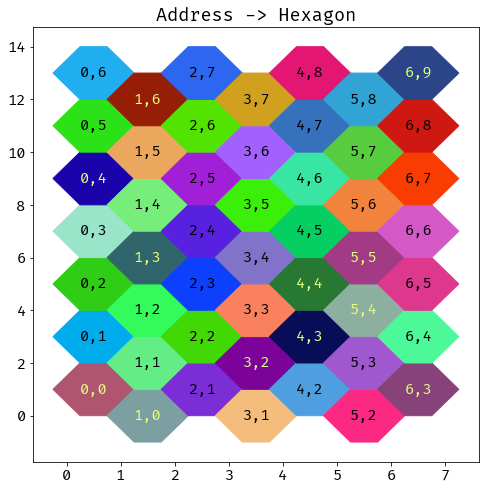

In [19]:
from matplotlib import colors
def plot_hex(ax, i, j):
    # Find the origin coordinates for the current hex
    x, y = axial_to_world(i, j)
    # Get the "random" color for it
    color = color_for_hex(i, j)
    # Offset the hex geometry according to the origin
    points = hex_points()+np.array([x,y])
    # Plot the hex
    ax.fill(*points.transpose(), color=color)

    # Add a text annotation so we can see the hex address
    # Naive algorithm to pick a contrasty text color
    text_color = colors.rgb_to_hsv(color)
    text_color[1] = 0.5
    text_color[2] = np.round(1.2-text_color[2])
    text_color[0] = 0.6 if text_color[2] < 0.5 else 0.2
        
    text_color = colors.hsv_to_rgb(text_color)
    ax.annotate(f'{i},{j}', (x+0.5, y+1), horizontalalignment='center', verticalalignment='center', color=text_color)
    
def hex_grid_subplot(axes):
    for i in range(0, 7):
        for j in range(0, 7):
            j = j + i//2
            plot_hex(axes, i, j)
    axes.set_title('Address -> Hexagon')

fig = plt.figure(figsize=(8,8))
hex_grid_subplot(plt.subplot())

## Finding the hexagon address for a cartesian coordinate

The function `axial_to_world` finds the "origin" coordinates of a hexagon, given its address - we then draw a polygon relative to this to obtain the hexagons on the above image. The hexagon produced by this process is effectively the preimage of the hexagon index in the funtion $f$ that we wish to find.

Therefore, we can start forming $f$ by inverting the calculation in `axial_to_world`. Of course the inverse is only properly defined for coordinate pairs that sit on one of the hex origins - for other values, perform the inverse calculation anyway and keep only the integral part by taking the floor.


In [8]:
def axial_to_world_inverse(x: float, y: float) -> (int, int):
    i = x
    j = (y+i)/2

    return map(lambda v: np.int(np.floor(v)), (i, j))

i, j = (23, 33)
x, y = axial_to_world(i, j)
print(f'axial_to_world{i, j} -> {x, y}')
x, y = (23.4, 43.1)
i, j = axial_to_world_inverse(x, y)
print(f'axial_to_world_inverse{x, y} -> {i, j}')

axial_to_world(23, 33) -> (23.0, 43.0)
axial_to_world_inverse(23.4, 43.1) -> (23, 33)


We now have a map from the real space to the hexagon coordinates, but it only finds the coordinates at the "origin" of the hexagon, and otherwise rounds down. For example, for the hexagon shown in blue below, the inverse function will identify all of the points in the pink square with the address of this hexagon.

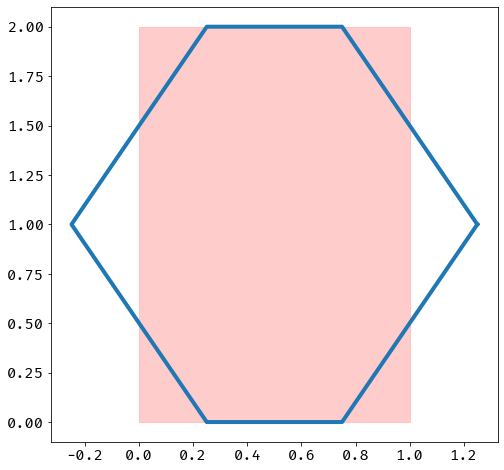

In [9]:
plt.figure(figsize=(8,8))
plt.plot(*hex_points().transpose(), lw=4)
plt.fill(*np.array([[0,0],[1,0],[1,2],[0,2],[0,0]]).transpose(), color='#ffaaaa99')
None

The intersection of the pink square and blue hexagon is already correctly identified by the inverse. The four corners of the square need to be mapped to adjacent hexagons instead.

Fortunately, we can use a property of the axial address already mentioned: moving in a particular direction (across an edge to an adjacent hexagon) always changes the axial address in the same way irrespective of where the starting hexagon is - i.e. we can use the $\nearrow$, $\searrow$ etc operations to move to the correct address if we are in one of the corners of the pink box.

If we rescale the y axis by $1/2$ the pink box will become a square and it is trivial to find if we are in one of the corners that lies outside the hexgon and determine the correct move operation:


In [10]:
def world_to_axial(x: float, y: float) -> (int, int):
    i = np.int(np.floor(x))
    j = np.int(np.floor((y+i)/2))
    
    origin_x, origin_y = axial_to_world(i, j)
    local_x = x - origin_x
    local_y = (y - origin_y)/2
    
    if local_x + local_y < 0.25:
        return i-1, j-1
    elif local_x + (1-local_y) < 0.25:
        return i-1, j
    elif (1-local_x) + (1-local_y) < 0.25:
        return i+1, j+1
    elif (1-local_x) + local_y < 0.25:
        return i+1, j
    else:
        return i, j
        


To demonstrate this function, construct an image by iterating over the coordinate space and finding the axial address for each real valued location. If we color in the image according to the same colour scheme we used before, we can compare the generated image to the plot of the hexagon grid to confirm that it works.

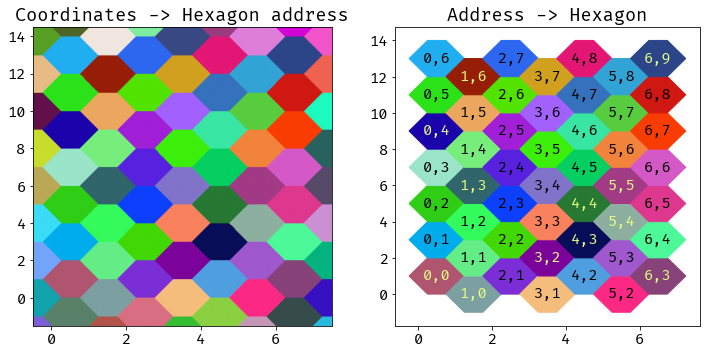

In [20]:
x_values = np.linspace(-0.5,7.5,600)
y_values = np.linspace(-1.5,14.5,600)

def generate_image():
    img_rgba = np.zeros((len(y_values), len(x_values), 3), dtype=np.float)
    for j, y in enumerate(y_values):
        for i, x in enumerate(x_values):
            img_rgba[j, i, :] = color_for_hex(*world_to_axial(x,y))
    return img_rgba

def image_subplot(axes):
    axes.imshow(generate_image(), 
                origin='lower', 
                extent=(x_values[0], x_values[-1], y_values[0], y_values[-1]), 
                aspect=0.5)
    axes.set_title('Coordinates -> Hexagon address')

plt.figure(figsize=(12,5.5))
image_subplot(plt.subplot(1, 2, 1))
hex_grid_subplot(plt.subplot(1, 2, 2))


## References

There are comprehensive details on hexagonal grids here: https://www.redblobgames.com/grids/hexagons/